In [21]:
# --- 1. 필요 라이브러리 임포트 ---
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from types import SimpleNamespace

# 위에서 작성한 mraugmenter.py 파일에서 클래스를 가져옵니다.
from MRaugmenter import MRAugmenter, Config




In [22]:

# --- 3. MRAugmenter 설정 정의 ---
# 모든 파라미터를 하나의 객체로 관리하여 편리합니다.
config = Config()


In [23]:

# --- 4. PyTorch Dataset 정의 ---

class MRIDataset(Dataset):
    def __init__(self, h5_path, augmenter_config):
        self.h5_path = h5_path
        with h5py.File(h5_path, 'r') as f:
            self.num_slices = f['kspace'].shape[0]
            
        self.augmenter = MRAugmenter(augmenter_config)
        self.current_epoch = 0

    def set_epoch(self, epoch):
        """훈련 루프에서 매 에포크 시작 시 호출하여 현재 에포크를 알려줍니다."""
        self.current_epoch = epoch
        
    def __len__(self):
        return self.num_slices
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            kspace_slice = f['kspace'][idx] # (Coil, H, W), numpy array
            mask = f['mask'][:]

        kspace_slice = np.fft.fftshift(kspace_slice, axes=(-2, -1))

        # 이제 kspace_slice는 확실히 '중앙 정렬'된 상태입니다.
        target_size = (kspace_slice.shape[1], kspace_slice.shape[2])
        aug_kspace, aug_target = self.augmenter(kspace_slice, target_size, self.current_epoch)
        
        # 언더샘플링된 k-space는 이제 중앙 정렬된 aug_kspace를 기반으로 합니다.
        undersampled_kspace = aug_kspace * torch.from_numpy(mask)
        
        return {
            'undersampled_kspace': undersampled_kspace,
            'augmented_target': aug_target,
            # 비교를 위한 원본 k-space도 중앙 정렬된 버전을 사용합니다.
            'original_kspace': torch.from_numpy(kspace_slice),
        }

/var/folders/9l/zwsxf59976sffc3wv1cj884c0000gn/T/ipykernel_97758/2524966357.py:40: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/9l/zwsxf59976sffc3wv1cj884c0000gn/T/ipykernel_97758/2524966357.py:40: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/9l/zwsxf59976sffc3wv1cj884c0000gn/T/ipykernel_97758/2524966357.py:40: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/9l/zwsxf59976sffc3wv1cj884c0000gn/T/ipykernel_97758/2524966357.py:40: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/var/folders/9l/zwsxf59976sffc3wv1cj884c0000gn/T/ipykernel_97758/2524966357.py:40: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.


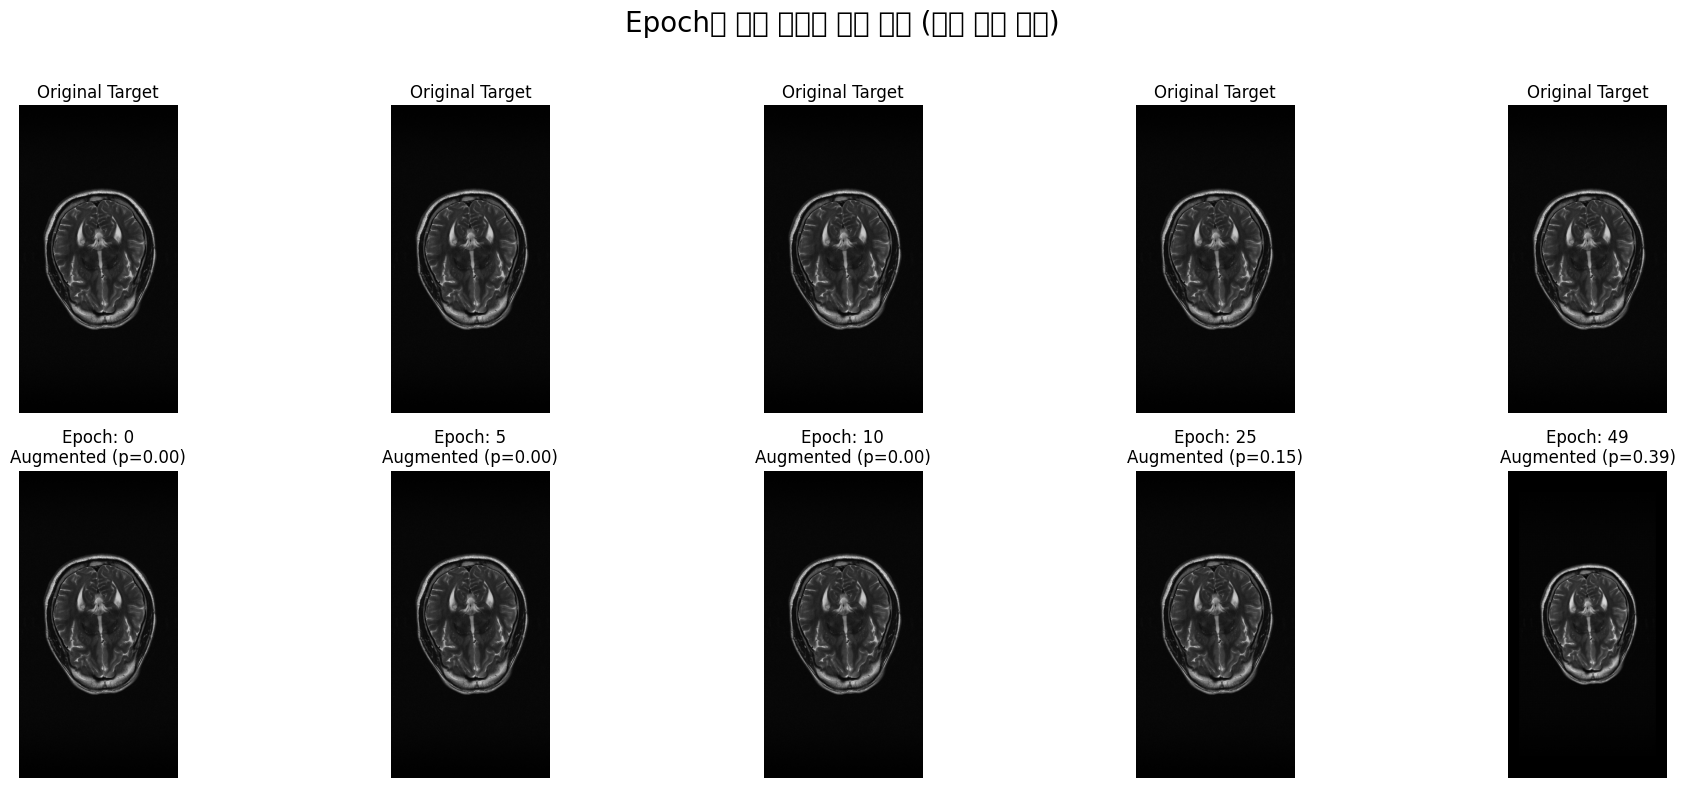

In [26]:
# --- 5. 시각화를 통한 증강 효과 확인 (최종 수정) ---
DUMMY_FILE = 'brain_acc4_86.h5'

# 데이터셋 인스턴스 생성
dataset = MRIDataset(DUMMY_FILE, config)

# 시각화할 에포크들
epochs_to_show = [0, 5, 10, 25, 49]

fig, axes = plt.subplots(2, len(epochs_to_show), figsize=(20, 8))
fig.suptitle("Epoch에 따른 데이터 증강 변화 (중앙 정렬 적용)", fontsize=20)

for i, epoch in enumerate(epochs_to_show):
    dataset.set_epoch(epoch)
    sample = dataset[0] # 첫 번째 슬라이스만 확인
    
    # 현재 증강 확률 가져오기
    p = dataset.augmenter.schedule_p(epoch)
    
    # 원본 이미지 (비교 기준)
    original_kspace = sample['original_kspace']
    original_target = torch.sqrt(torch.sum(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(original_kspace, dim=(-2,-1)), norm='ortho'))**2, dim=0))

    # 증강된 타겟 이미지
    augmented_target = sample['augmented_target']

    # 흩어진 이미지의 사분면을 교환하여 중앙으로 모읍니다.
    centered_original_target = torch.fft.fftshift(original_target)
    centered_augmented_target = augmented_target
    
    # 플로팅
    axes[0, i].imshow(centered_original_target.numpy(), cmap='gray')
    axes[0, i].set_title(f"Original Target")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(centered_augmented_target.numpy(), cmap='gray')
    axes[1, i].set_title(f"Epoch: {epoch}\nAugmented (p={p:.2f})")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()